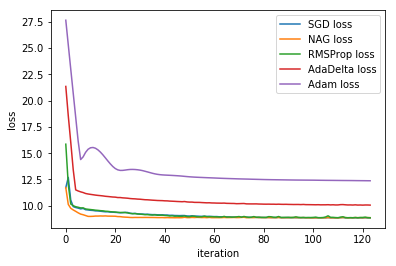

Accuracy of SGD: 0.833548307843
Accuracy of NAG: 0.836496529697
Accuracy of RMSProp: 0.8359437381
Accuracy of AdaDelta: 0.835513789079
Accuracy of Adam: 0.834960997482


In [1]:
# -*- coding: utf-8 -*-
from sklearn.datasets import load_svmlight_file
from sklearn.utils import shuffle
import numpy as np
from matplotlib import pyplot as plt

X_train, y_train = load_svmlight_file("F:/大三上/机器学习/实验二/a9a.txt", n_features = 123)
X_test, y_test = load_svmlight_file("F:/大三上/机器学习/实验二/a9a.t", n_features = 123)
X_train = X_train.toarray()
X_test = X_test.toarray()

#在训练集前添加一列1
X_train = np.c_[np.ones(len(X_train)), X_train]
X_test = np.c_[np.ones(len(X_test)), X_test]

def hinge_loss(x):
    return max(0, 1 - x)

#least squares loss
def loss_function(X, y, w, C):
    return (w ** 2).sum() / 2 + C * np.mean(np.maximum(0, 1 - y * (np.dot(X, w))))
#    return (w ** 2).sum() / 2 + C * sum(map(hinge_loss, y * (np.dot(X, w))))

def gradient(X, y, w, C):
    temp = np.zeros(len(w))
    for i in range(X.shape[0]):
        if y[i] * np.dot(X[i,:], w) < 1:
            temp += -y[i] * X[i,:]
    return w + C * temp / len(y)

def accuracy(X, y, w):
    return sum(np.sign(np.dot(X, w)) == y) / len(X)

def SGD(X, y, w, _lambda, learning_rate, X_test, y_test, loss):
    w = w - learning_rate * gradient(X, y, w, _lambda)
    loss.append(loss_function(X_test, y_test, w, _lambda))
    return w

def NAG(X, y, w, v, _lambda, gamma, learning_rate, X_test, y_test, loss):
    g = gradient(X, y, w - gamma * v, _lambda)
    v = gamma * v + learning_rate * g
    w = w - v
    loss.append(loss_function(X_test, y_test, w, _lambda))
    return w, v

def RMSProp(X, y, w, G, _lambda, learning_rate, gamma, epsilon, X_test, y_test, loss):
    g = gradient(X, y, w, _lambda)
    G = gamma * G + (1 - gamma) * g * g
    w = w - learning_rate / (np.sqrt(G + epsilon)) * g
    loss.append(loss_function(X_test, y_test, w, _lambda))
    return w, G

def AdaDelta(X, y, w, G, delta, _lambda, gamma, epsilon, X_test, y_test, loss):
    g = gradient(X, y, w, _lambda)
    G = gamma * G + (1 - gamma) * g * g
    delta_w = - np.sqrt(delta + epsilon) / np.sqrt(G + epsilon) * g
    w = w + delta_w
    delta = gamma * delta + (1 - gamma) * delta_w * delta_w
    loss.append(loss_function(X_test, y_test, w, _lambda))
    return w, G, delta

def Adam(X, y, w, v, G, _lambda, beta, gamma, learning_rate, t, epsilon, X_test, y_test, loss):
    g = gradient(X, y, w, _lambda)
    v = beta * v + (1 - beta) * g
    G = gamma * G + (1 - gamma) * g * g
    _v = v / (1 - beta ** t)
    _G = G / (1 - gamma ** t)
    w = w - learning_rate * _v / np.sqrt(_G + epsilon)
    loss.append(loss_function(X_test, y_test, w, _lambda))
    return w, v, G


#参数初始化
epochs = 4
batch_size = 1024
iteration_per_epoch = int(X_train.shape[0]/batch_size)
zero_w = np.zeros(X_train.shape[1])
zero_v = np.zeros(X_train.shape[1])
zero_G = np.zeros(X_train.shape[1])
w = {'SGD': zero_w, 'NAG': zero_w, 'RMSProp':zero_w, 'AdaDelta':zero_w, 'Adam': zero_w}
v = {'NAG': zero_v, 'Adam': zero_v}
G = {'RMSProp': zero_G, 'AdaDelta': zero_G, 'Adam': zero_G}

delta = np.zeros(X_train.shape[1])
C = {'SGD': 21, 'NAG': 21, 'RMSProp': 21, 'AdaDelta': 24, 'Adam': 30}
learning_rate = {'SGD': 0.01, 'NAG': 0.01, 'RMSProp': 0.01, 'Adam': 0.01}
gamma = {'NAG': 0.9, 'RMSProp': 0.9, 'AdaDelta': 0.95, 'Adam': 0.999}
epsilon = {'RMSProp': 1e-6, 'AdaDelta': 1e-5, 'Adam': 1e-6}
beta = 0.9

SGD_validation_loss, NAG_validation_loss, RMSProp_validation_loss, AdaDelta_validation_loss, Adam_validation_loss = [], [], [], [], []

for i in range(epochs):
    X, y = shuffle(X_train, y_train)
    for j in range(iteration_per_epoch):
        start = j*batch_size
        end = start + batch_size
        w['SGD'] = SGD(X[start:end], y[start:end], w['SGD'], C['SGD'], learning_rate['SGD'], X_test, y_test, SGD_validation_loss)
        w['NAG'], v['NAG'] = NAG(X[start:end], y[start:end], w['NAG'], v['NAG'], C['NAG'], gamma['NAG'], learning_rate['NAG'], X_test, y_test, NAG_validation_loss)
        w['RMSProp'], G['RMSProp'] = RMSProp(X[start:end], y[start:end], w['RMSProp'], G['RMSProp'], C['RMSProp'], learning_rate['RMSProp'], gamma['RMSProp'], epsilon['RMSProp'], X_test, y_test, RMSProp_validation_loss)
        w['AdaDelta'], G['AdaDelta'], delta = AdaDelta(X[start:end], y[start:end], w['AdaDelta'], G['AdaDelta'], delta, C['AdaDelta'], gamma['AdaDelta'], epsilon['AdaDelta'], X_test, y_test, AdaDelta_validation_loss)
        w['Adam'], v['Adam'], G['Adam'] = Adam(X[start:end], y[start:end], w['Adam'], v['Adam'], G['Adam'], C['Adam'], beta, gamma['Adam'], learning_rate['Adam'], (i * iteration_per_epoch + j + 1), epsilon['Adam'], X_test, y_test, Adam_validation_loss)

plt.plot(range(epochs * iteration_per_epoch),SGD_validation_loss, label='SGD loss')
plt.plot(range(epochs * iteration_per_epoch),NAG_validation_loss, label='NAG loss')
plt.plot(range(epochs * iteration_per_epoch),RMSProp_validation_loss, label='RMSProp loss')
plt.plot(range(epochs * iteration_per_epoch),AdaDelta_validation_loss, label='AdaDelta loss')
plt.plot(range(epochs * iteration_per_epoch),Adam_validation_loss, label='Adam loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.show()

print('Accuracy of SGD:', accuracy(X_test, y_test, w['SGD']))
print('Accuracy of NAG:', accuracy(X_test, y_test, w['NAG']))
print('Accuracy of RMSProp:', accuracy(X_test, y_test, w['RMSProp']))
print('Accuracy of AdaDelta:', accuracy(X_test, y_test, w['AdaDelta']))
print('Accuracy of Adam:', accuracy(X_test, y_test, w['Adam']))
